<div style="text-align: right">INFO 6105 Data Science Eng Methods and Tools, Lecture 6 Day 1</div>
<div style="text-align: right">Dino Konstantopoulos, 18 February 2020</div>

# Generating random numbers with arbitrary distribution

<br />
<center>
<img src="https://lh3.googleusercontent.com/proxy/esNL8Fvnror8Vg2SSxLxuPGXCmwLme379RZSoy3AIc-lUkHF_8vkq-4CC84I6hC3Tcb9zEaWOrfO-LnRSGcFAHhqjYicjzwf1uxVnZzuRBW14zBQ9ibk0B8sBfVX1HHo4HSWmnKomqQp4N0S2AC5H6AyhE4gUkW9uRewstMg6Vw2lzWOhhjH7XqiJ21cinQYV9j7" width=400 />
</center>

The reason why we use well-known model functions (like the normal or the gamma) in statistics is because of the ***huge*** dimensionality reduction when you use an analytic function: All you need to find out are its parameters, which is usually one, two, or three!

However, with a little bit of coding, you actually *don't need any math at all*, which is what I told you at the beginning of the semester. Either you *know the math*, or you *write the code*! In this notebook, we'll write the code for our model instead of doing the math. This results in a not-so-dramatic dimensionality reduction, but it's still wicked cool.

## 1. Warm-up

Let's generate random variates from a normal distribution, then plot the histogram of the data. You *always* start with a nomral distribution in statistics!

In [1]:
import scipy.stats
import numpy as np
data = scipy.stats.norm.rvs(size=100000, loc=0, scale=1.5, random_state=123)
hist = np.histogram(data, bins=100)

In [2]:
len(data)

100000

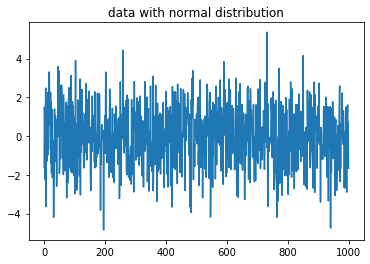

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.title("data with normal distribution")
plt.plot(data[0:1000], label='data')
plt.show()

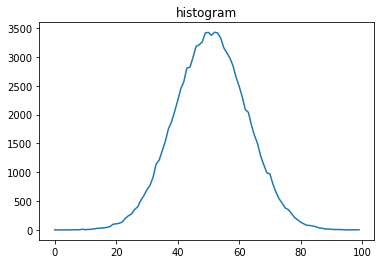

In [4]:
plt.title("histogram")
plt.plot(hist[0], label='histogram')
plt.show()

`scipy.stats.rv_histogram` is a neat API: It produces a pdf from a histogram.

> Huh?! Yup, `scipy.stats.rv_histogram` is essentially the answer to your homework. A single API call! If you only knew your libraries, imagine how much GoT you could watch!

In [5]:
hist_dist = scipy.stats.rv_histogram(hist)

`hist_dist` behaves like an ordinary scipy rv_continuous distribution. For example, we can obtain its pdf and cdf:

In [6]:
hist_dist.pdf(1.0)

0.20538577847618705

In [7]:
 hist_dist.cdf(2.0)

0.908185685430565

PDF is zero above the highest bin of the histogram, and also below the lowest bin of the histogram, defined by the max and min of the original dataset:

In [8]:
print(hist_dist.pdf(np.max(data)))
print(hist_dist.cdf(np.max(data)))
print(hist_dist.pdf(np.min(data)))
print(hist_dist.cdf(np.min(data)))

0.0
1.0
7.759190724449831e-05
0.0


Let's plot the PDF on top of the histogram we obtained from our data to see if it matches:

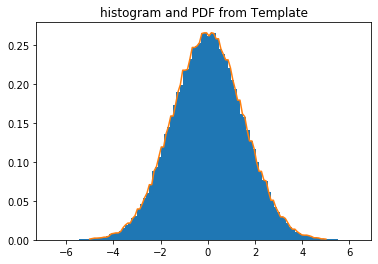

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
X = np.linspace(-5.0, 5.0, 100)
plt.title("histogram and PDF from Template")
plt.hist(data, density=True, bins=100)
plt.plot(X, hist_dist.pdf(X), label='PDF')
plt.show()

Now let's also plot the CDF on top of the histogram we obtained from our data:

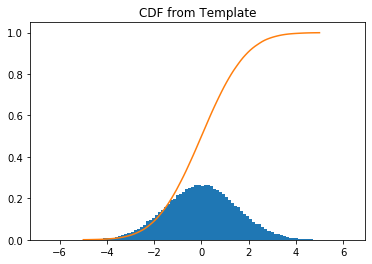

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
X = np.linspace(-5.0, 5.0, 100)
plt.title("CDF from Template")
plt.hist(data, density=True, bins=100)
plt.plot(X, hist_dist.cdf(X), label='CDF')
plt.show()

## 2. Intuition

To really do your homework, what you need to create is a **lookup table**. The histogram gives us bins of frequency. When we generate random variates, we lookup those bins *with priority proportional to how big they are*. 

The intuition comes from genetic algorithms' (GA) roulette wheel, a.k.a. [fitness-proportionate selection](https://en.wikipedia.org/wiki/Fitness_proportionate_selection), as we will see further down.

Anyway, this is our *input* histogram:

In [28]:
hist[0]

array([   1,    0,    0,    1,    0,    1,    2,    3,    3,   11,    5,
          8,   12,   20,   28,   31,   35,   44,   59,   98,  106,  114,
        138,  201,  246,  277,  355,  398,  510,  594,  695,  772,  912,
       1140, 1213, 1374, 1536, 1752, 1874, 2049, 2237, 2445, 2567, 2807,
       2821, 2991, 3183, 3209, 3261, 3414, 3425, 3374, 3427, 3416, 3327,
       3159, 3072, 2979, 2846, 2647, 2492, 2311, 2087, 2038, 1819, 1636,
       1495, 1283, 1133,  990,  972,  793,  654,  539,  464,  380,  353,
        286,  217,  176,  135,  106,   81,   77,   67,   54,   34,   30,
         16,   16,   11,    6,    7,    6,    3,    0,    1,    2,    2,
          3], dtype=int64)

In [29]:
hist

(array([   1,    0,    0,    1,    0,    1,    2,    3,    3,   11,    5,
           8,   12,   20,   28,   31,   35,   44,   59,   98,  106,  114,
         138,  201,  246,  277,  355,  398,  510,  594,  695,  772,  912,
        1140, 1213, 1374, 1536, 1752, 1874, 2049, 2237, 2445, 2567, 2807,
        2821, 2991, 3183, 3209, 3261, 3414, 3425, 3374, 3427, 3416, 3327,
        3159, 3072, 2979, 2846, 2647, 2492, 2311, 2087, 2038, 1819, 1636,
        1495, 1283, 1133,  990,  972,  793,  654,  539,  464,  380,  353,
         286,  217,  176,  135,  106,   81,   77,   67,   54,   34,   30,
          16,   16,   11,    6,    7,    6,    3,    0,    1,    2,    2,
           3], dtype=int64),
 array([-6.61040116, -6.48152174, -6.35264232, -6.2237629 , -6.09488348,
        -5.96600406, -5.83712464, -5.70824522, -5.5793658 , -5.45048638,
        -5.32160696, -5.19272754, -5.06384812, -4.9349687 , -4.80608928,
        -4.67720986, -4.54833044, -4.41945102, -4.2905716 , -4.16169218,
        -4.03

Here is my *first cut* at the function: The idea was to create a number of workers, and to have workers work an amount of time proportional to the histogram. Then we interrupt the coroutine (by yielding) and see which worker was active:

<br />
<center>
<img src="https://media0.giphy.com/media/oDrajdEXgcAvK/source.gif" width=400 />
    Working, working, working...
</center>

And as soon as I finished writing this, I thought *this is exactly GA roulette wheel selection*! Here it is, as simple as possible:

In [30]:
hsgm = hist[0]

class Chromosome:
    def __init__(self, idx, fit):
        self.fitness = fit
        self.index = idx
        
Chromosomes = []

#for _ in hsgm:
#i = 0
 #   Chromosomes.append(Chromosome(i,_))
  #  i+=1
    
for i, _ in enumerate(hsgm):
    Chromosomes.append(Chromosome(i, _))
    
Chromosomes[9].index, Chromosomes[9].fitness 

(9, 11)

And with a little bit of experience, you *know* [np.random.choice](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.choice.html) is *the* API to use:

In [31]:
def selectOne(population):
    maximum = sum([c.fitness for c in population])
    selection_probs = [c.fitness/maximum for c in population]
    return population[np.random.choice(len(population), p=selection_probs)]

In [40]:
c = selectOne(Chromosomes)
c.index, c.fitness

(41, 2445)

You will write the full algorithm without "*cheating*" by using `np.random.choice`:

First, sort the weights in ascending order, and zip them, together with the indeces:
```(python)
    sorted_indexed_weights = sorted(enumerate(weights), key=operator.itemgetter(1));
    indices, sorted_weights = zip(*sorted_indexed_weights);
```

Then, calculate the cumulative probability (note that is a cdf!)
```(python)
    tot_sum = sum the sorted weights@
    prob = list comprehension: sorted_weights/tot_sum
    cum_prob = np.cumsum(prob)
```

Now select a random a number in the range \[0,1\]
```(python)
random_num = ...
````

Now find an index with that cum prob value
```(python)
    for index_value, cum_prob_value in zip(indices, cum_prob):
        if random_num < cum_prob_value:
            return index_value
```

In [48]:
import random
import operator

def roulette_selection(weights):
    '''performs roulette wheel selection on a list, returns the index selected from the list'''
    #sort the weights in ascending order
    sorted_indexed_weights = sorted(enumerate(weights),key=operator.itemgetter(1));
    indices, sorted_weights = zip(*sorted_indexed_weights);
    
    #calculate the cumulative probability (note that is a cdf)
    tot_sum = sum(sorted_weights)
    prob = [x/tot_sum for x in sorted_weights]
    cum_prob = np.cumsum(prob)
    
    #now select a random a number in the range [0，1]
    random_num = random.random()
    
    #now find an index with that
    for index_value, cum_prob_value in zip(indices, cum_prob):
        if random_num < cum_prob_value:
            return index_value


In [49]:
roulette_selection(hsgm)

53

The input to your homework function is a histogram $h$ (with any number of bins), a range $r$ to generate values from, and the number $n$ of desired random variates.

Let's break down the input interval into *as many intervals as there are bins in the input histogram*. Then we use roulette wheel selection to pick one of these bins. Then we generate a random float within the interval of that bin, and that is our first random variate!

In [50]:
# inputs
h = hsgm
r = range(-1, 1)
n = 10000

# we build
x = np.linspace(r.start, r.stop, len(hsgm))
x[0], x[len(hsgm)//2], x[len(hsgm)-1]

(-1.0, 0.010101010101010166, 1.0)

In [51]:
i = roulette_selection(h)
if i == len(hsgm) - 1: i -= 1
x[i], x[i+1]

(0.19191919191919204, 0.21212121212121215)

In [52]:
random.uniform(x[i], x[i+1])

0.20152471103341144

ready?

In [53]:
my_random_variates = []
for _ in range(n):
    i = roulette_selection(h)
    my_random_variates.append(random.uniform(x[i], x[i+1]))

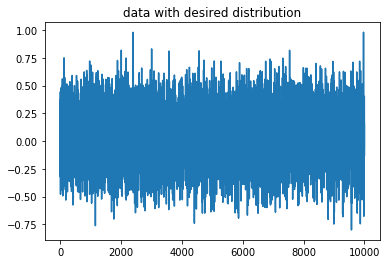

In [54]:
plt.title("data with desired distribution")
plt.plot(my_random_variates, label='data')
plt.show()

In [55]:
my_not_so_random_histogram = np.histogram(my_random_variates, bins=len(hsgm))

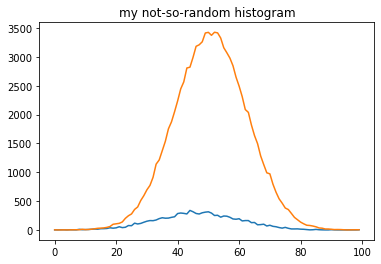

In [58]:
plt.title("my not-so-random histogram")
plt.plot(my_not_so_random_histogram[0], label='histogram')
plt.plot(hsgm, label='original histogram')
plt.show()

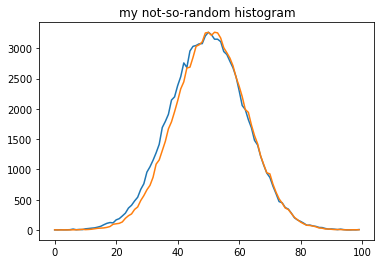

In [60]:
plt.title("my not-so-random histogram")
plt.plot(my_not_so_random_histogram[0], label='histogram')
plt.plot(hsgm*max(my_not_so_random_histogram[0])/max(hsgm), label='original histogram')
plt.show()

And... what if we generate ten times more datapoints, say 100,000?

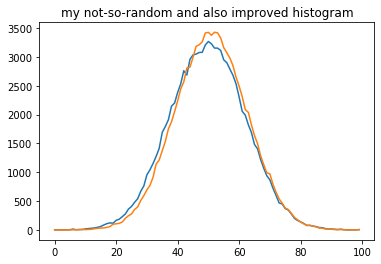

In [59]:
my_random_variates = []
for _ in range(10 * n):
    i = roulette_selection(h)
    if i == len(hsgm) - 1: i -= 1
    my_random_variates.append(random.uniform(x[i], x[i+1]))
    
my_not_so_random_histogram = np.histogram(my_random_variates, bins=len(hsgm))

plt.title("my not-so-random and also improved histogram")
plt.plot(my_not_so_random_histogram[0], label='generated histogram')
plt.plot(hsgm, label='original histogram')
plt.show()

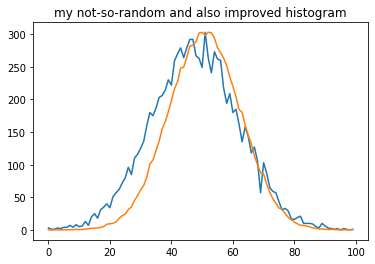

In [62]:
my_random_variates = []
for _ in range(n):
    i = roulette_selection(h)
    if i == len(hsgm) - 1: i -= 1
    my_random_variates.append(random.uniform(x[i], x[i+1]))
    
my_not_so_random_histogram = np.histogram(my_random_variates, bins=len(hsgm))

plt.title("my not-so-random and also improved histogram")
plt.plot(my_not_so_random_histogram[0], label='generated histogram')
plt.plot(hsgm*max(my_not_so_random_histogram[0])/max(hsgm), label='original histogram')
plt.show()

Getting closer and closer the more random variates I produce! This is the key to *frequentist statistics*. If i have tons of data, then I'm in good shape. However, *when we don't have enough data*, which is the *sweet spot( of state of the art ML, that is when we turn to *Bayesian statistics*!

## 3. Random variates from histogram

Ok, we wrote the *prototype*, but now we're ready to write a general class that leveerages key probability concepts such as **pdf** and **cdf** to to the job.

The following class will generate random variates, given a histogram. Note how I reduced tab spaces, long notebook cells get prettier that way.

In [101]:
import pylab
import numpy

class GeneralRandom:
  """This class enables us to generate random numbers with an arbitrary 
  distribution."""
  
  def __init__(self, x = pylab.arange(-1.0, 1.0, .01), p = None, Nrl = 1000):
    """Initialize the lookup table (with default values if necessary)
    Inputs:
    x = random number values
    p = probability density profile at that point
    Nrl = number of reverse look up values between 0 and 1"""  
    
    if not isinstance(p, numpy.ndarray):
        if not isinstance(p, tuple):
            if p == None:
                p = pylab.exp(-10*x**2.0)
    self.set_pdf(x, p, Nrl)
   

  def set_pdf(self, x, p, Nrl = 1000):
    """Generate the lookup tables. 
    x is the value of the random variate
    pdf is its probability density
    cdf is the cumulative pdf
    inversecdf is the inverse look up table"""
    
    self.x = x
    if isinstance(p, tuple):
        self.pdf = p/sum(p) #normalize it
    else:
        self.pdf = p/p.sum() #normalize it
        
    self.cdf = self.pdf.cumsum()
    self.inversecdfbins = Nrl
    self.Nrl = Nrl
    
    y = pylab.arange(Nrl)/float(Nrl)
    delta = 1.0/Nrl
    self.inversecdf = pylab.zeros(Nrl)    
    self.inversecdf[0] = self.x[0]
    cdf_idx = 0
    
    for n in range(1,self.inversecdfbins):
        while self.cdf[cdf_idx] < y[n] and cdf_idx < Nrl:
            cdf_idx += 1
        self.inversecdf[n] = self.x[cdf_idx-1] + (self.x[cdf_idx] - self.x[cdf_idx-1]) * (y[n] - self.cdf[cdf_idx-1])/(self.cdf[cdf_idx] - self.cdf[cdf_idx-1]) 
        if cdf_idx >= Nrl:
            break
    self.delta_inversecdf = pylab.concatenate((pylab.diff(self.inversecdf), [0]))
              
  def random(self, N = 1000):
    """Give us N random numbers with the requested distribution"""

    idx_f = numpy.random.uniform(size = N, high = self.Nrl-1)
    idx = pylab.array([idx_f],'i')
    y = self.inversecdf[idx] + (idx_f - idx)*self.delta_inversecdf[idx]

    return y
  
  def plot_pdf(self):
    pylab.plot(self.x, self.pdf)
    
  def self_test(self, N = 1000):
    pylab.figure()
    #The cdf
    pylab.subplot(2,2,1)
    pylab.plot(self.x, self.cdf)
    #The inverse cdf
    pylab.subplot(2,2,2)
    y = pylab.arange(self.Nrl)/float(self.Nrl)
    pylab.plot(y, self.inversecdf)
    
    #The actual generated numbers
    pylab.subplot(2,2,3)
    y = self.random(N)
    p1, edges = pylab.histogram(y, bins = 50, 
                                range = (self.x.min(), self.x.max()), 
                                normed = True)
    x1 = 0.5*(edges[0:-1] + edges[1:])
    pylab.plot(x1, p1/p1.max())
    pylab.plot(self.x, self.pdf/self.pdf.max())

C:\Users\liaoz\Anaconda3\lib\site-packages\ipykernel_launcher.py:80: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.


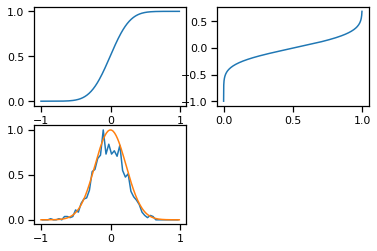

In [102]:
test = GeneralRandom()
test.self_test()

In [103]:
x = pylab.arange(-1.0, 1.0, .01)
pylab.exp(-10*x**2.0)

array([4.53999298e-05, 5.53961755e-05, 6.74583627e-05, 8.19828893e-05,
       9.94356357e-05, 1.20362805e-04, 1.45403198e-04, 1.75302063e-04,
       2.10926674e-04, 2.53283790e-04, 3.03539138e-04, 3.63039106e-04,
       4.33334765e-04, 5.16208399e-04, 6.13702669e-04, 7.28152539e-04,
       8.62220086e-04, 1.01893226e-03, 1.20172170e-03, 1.41447053e-03,
       1.66155727e-03, 1.94790664e-03, 2.27904223e-03, 2.66114180e-03,
       3.10109501e-03, 3.60656314e-03, 4.18604042e-03, 4.84891651e-03,
       5.60553935e-03, 6.46727781e-03, 7.44658307e-03, 8.55704807e-03,
       9.81346359e-03, 1.12318701e-02, 1.28296036e-02, 1.46253347e-02,
       1.66390989e-02, 1.88923160e-02, 2.14077987e-02, 2.42097460e-02,
       2.73237224e-02, 3.07766190e-02, 3.45965954e-02, 3.88130014e-02,
       4.34562758e-02, 4.85578213e-02, 5.41498541e-02, 6.02652275e-02,
       6.69372276e-02, 7.41993418e-02, 8.20849986e-02, 9.06272807e-02,
       9.98586094e-02, 1.09810404e-01, 1.20512717e-01, 1.31993843e-01,
      

In [104]:
type(data)

numpy.ndarray

In [105]:
data

array([-1.6284459 ,  1.49601817,  0.42446775, ...,  1.73824966,
        3.42561844, -1.97740727])

This is our histogram from above: generated through random variates of a normal distribution:

In [106]:
hist[0]

array([   1,    0,    0,    1,    0,    1,    2,    3,    3,   11,    5,
          8,   12,   20,   28,   31,   35,   44,   59,   98,  106,  114,
        138,  201,  246,  277,  355,  398,  510,  594,  695,  772,  912,
       1140, 1213, 1374, 1536, 1752, 1874, 2049, 2237, 2445, 2567, 2807,
       2821, 2991, 3183, 3209, 3261, 3414, 3425, 3374, 3427, 3416, 3327,
       3159, 3072, 2979, 2846, 2647, 2492, 2311, 2087, 2038, 1819, 1636,
       1495, 1283, 1133,  990,  972,  793,  654,  539,  464,  380,  353,
        286,  217,  176,  135,  106,   81,   77,   67,   54,   34,   30,
         16,   16,   11,    6,    7,    6,    3,    0,    1,    2,    2,
          3], dtype=int64)

In [107]:
type(hist_dist)

scipy.stats._continuous_distns.rv_histogram

In [108]:
hist_dist

So we have a histogram. Let's instantiate the class from that histogram in order to generate simulated data.

C:\Users\liaoz\Anaconda3\lib\site-packages\ipykernel_launcher.py:80: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.


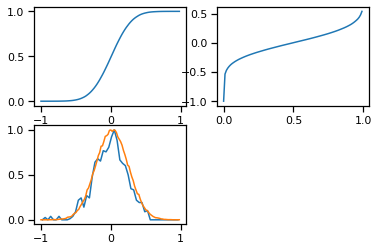

In [109]:
rvs_from_hist = GeneralRandom(x = pylab.arange(-1.0, 1.0, .02), p = hist[0], Nrl = 100)
rvs_from_hist.self_test()

Now let's generate random variates:

In [110]:
sim_data = rvs_from_hist.random()
sim_data

array([[ 1.22902616e-01,  3.21217785e-01,  9.15438609e-02,
        -6.74664952e-02, -8.70372333e-02, -7.40438991e-02,
        -3.64368647e-01,  2.37608771e-01, -1.51997725e-01,
        -4.10909105e-02, -2.66889338e-01, -6.35960580e-02,
        -1.99952591e-01,  4.12770006e-01, -7.05602733e-02,
        -2.13588365e-01,  4.45268481e-01,  3.29287484e-02,
         2.20699994e-01, -6.05607204e-02, -9.55592241e-02,
         1.20699623e-01,  2.02956291e-01, -2.88798477e-01,
        -8.59202271e-02,  2.11394939e-01, -1.26849689e-01,
        -1.04906213e-01,  1.14141723e-01,  9.71976730e-02,
         4.30512135e-01,  7.16297252e-02,  1.27310300e-01,
         2.45318003e-01, -1.81356572e-01,  1.09225028e-01,
         1.50382065e-01, -1.15567477e-01, -2.00425797e-01,
         7.20045041e-02, -1.80708457e-01, -2.28278835e-01,
        -1.88333070e-01, -9.58221083e-02, -1.65659715e-01,
        -8.74956039e-02, -1.94578786e-01,  2.70883898e-01,
         1.16459768e-01,  1.31967740e-01,  5.07774107e-0

In [111]:
sim_data[0]

array([ 1.22902616e-01,  3.21217785e-01,  9.15438609e-02, -6.74664952e-02,
       -8.70372333e-02, -7.40438991e-02, -3.64368647e-01,  2.37608771e-01,
       -1.51997725e-01, -4.10909105e-02, -2.66889338e-01, -6.35960580e-02,
       -1.99952591e-01,  4.12770006e-01, -7.05602733e-02, -2.13588365e-01,
        4.45268481e-01,  3.29287484e-02,  2.20699994e-01, -6.05607204e-02,
       -9.55592241e-02,  1.20699623e-01,  2.02956291e-01, -2.88798477e-01,
       -8.59202271e-02,  2.11394939e-01, -1.26849689e-01, -1.04906213e-01,
        1.14141723e-01,  9.71976730e-02,  4.30512135e-01,  7.16297252e-02,
        1.27310300e-01,  2.45318003e-01, -1.81356572e-01,  1.09225028e-01,
        1.50382065e-01, -1.15567477e-01, -2.00425797e-01,  7.20045041e-02,
       -1.80708457e-01, -2.28278835e-01, -1.88333070e-01, -9.58221083e-02,
       -1.65659715e-01, -8.74956039e-02, -1.94578786e-01,  2.70883898e-01,
        1.16459768e-01,  1.31967740e-01,  5.07774107e-02, -3.39743089e-01,
        2.82821343e-02,  

In [112]:
len(sim_data[0])

1000

What does the data look like?

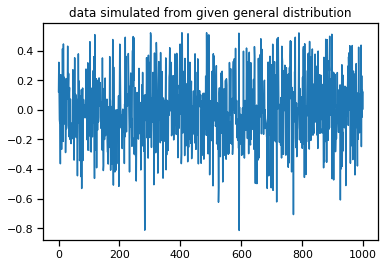

In [113]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.title("data simulated from given general distribution")
plt.plot(sim_data[0], label='sim_data')
plt.show()

Let's evaluate the histogram from the data, and also use `scipy.stats.rv_histogram` to generate random variates from that histogram:

In [114]:
hist2 = np.histogram(sim_data, bins=100)
hist2_dist = scipy.stats.rv_histogram(hist2)

Let's plot the histogram of the random variates on top of the pdf from random variates from of the histogram of the random variates:

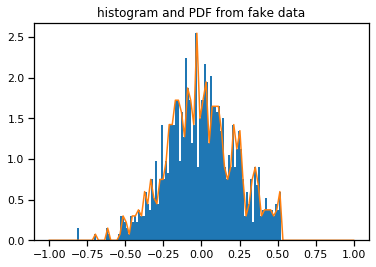

In [115]:
import matplotlib.pyplot as plt
%matplotlib inline
X = np.linspace(-1.0, 1.0, 100)
plt.title("histogram and PDF from fake data")
plt.hist(sim_data[0], density=True, bins=100)
plt.plot(X, hist2_dist.pdf(X), label='PDF')
plt.show()

Let's do it again. Now we use the histogram above as the input to our class.

C:\Users\liaoz\Anaconda3\lib\site-packages\ipykernel_launcher.py:80: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.


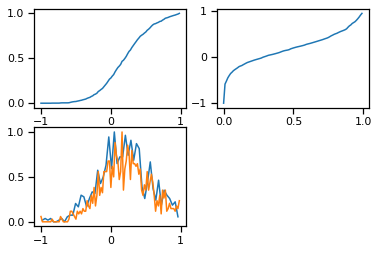

In [116]:
rvs_from_hist2 = GeneralRandom(x = pylab.arange(-1.0, 1.0, .02), p = hist2[0], Nrl = 100)
rvs_from_hist2.self_test()

In [117]:
sim_data2 = rvs_from_hist2.random()
sim_data2

array([[ 1.89177640e-01,  5.76166771e-02,  5.12484338e-01,
         7.42281014e-01,  6.79542081e-01,  9.41762248e-01,
         1.30603364e-01,  1.99096404e-01,  1.86067253e-01,
         5.10394520e-01,  6.87369510e-01,  2.49732205e-01,
        -2.65212255e-01,  5.12373793e-01,  3.08528100e-01,
        -4.10066697e-02,  5.77766617e-01,  8.59654552e-01,
        -8.30210417e-02,  1.93025085e-01, -3.02264996e-02,
         7.87102626e-01,  1.99789504e-01, -5.20864066e-02,
        -8.92911872e-01, -2.14794394e-01, -2.64299531e-01,
         9.12820119e-02,  3.53954657e-02,  3.17456758e-01,
        -3.31806127e-01,  1.33712548e-01,  1.96485296e-01,
         7.52387225e-01,  2.19556228e-01,  2.80664009e-01,
         5.09025758e-01, -2.26746901e-01,  5.19168083e-01,
        -9.52332850e-02,  1.48299365e-01,  2.61894616e-01,
         5.28928177e-01,  5.27472402e-01,  6.91257044e-02,
         2.53089952e-01,  2.82241725e-01,  2.29769749e-01,
         5.41434051e-01,  2.27262052e-01, -2.33564214e-0

Notice how the histograms degenerate in shape as we mirror out the process..

In [118]:
hist3 = np.histogram(sim_data2, bins=100)
hist3_dist = scipy.stats.rv_histogram(hist3)

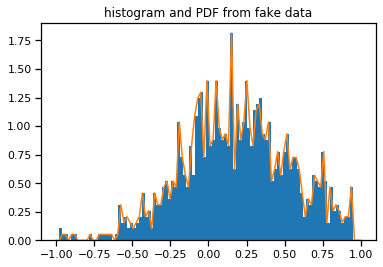

In [119]:
import matplotlib.pyplot as plt
%matplotlib inline
X = np.linspace(-1.0, 1.0, 100)
plt.title("histogram and PDF from fake data")
plt.hist(sim_data2[0], density=True, bins=100)
plt.plot(X, hist3_dist.pdf(X), label='PDF')
plt.show()

## 4. Empirical data

Now, we'll use empirical rather than simulated data: Tennesse rainfall.

In [120]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
sns.set_context('notebook')

In [121]:
precip = pd.read_table("data/nashville_precip.txt", index_col=0, na_values='NA', delim_whitespace=True)
precip.head()

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
1871,2.76,4.58,5.01,4.13,3.30,2.98,1.58,2.36,0.95,1.31,2.13,1.65
1872,2.32,2.11,3.14,5.91,3.09,5.17,6.10,1.65,4.50,1.58,2.25,2.38
1873,2.96,7.14,4.11,3.59,6.31,4.20,4.63,2.36,1.81,4.28,4.36,5.94
1874,5.22,9.23,5.36,11.84,1.49,2.87,2.65,3.52,3.12,2.63,6.12,4.19
1875,6.15,3.06,8.14,4.22,1.73,5.63,8.12,1.60,3.79,1.25,5.46,4.30


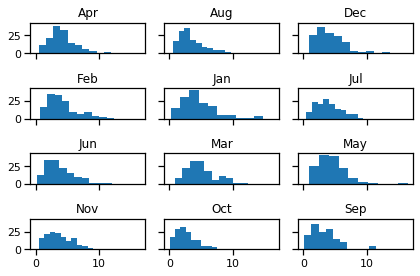

In [122]:
_ = precip.hist(sharex=True, sharey=True, grid=False)
plt.tight_layout()

In [123]:
precip.fillna(value={'Oct': precip.Oct.mean()}, inplace=True)

This is precipitation for the month of April and its histogram:

In [124]:
precip.Apr

Year
1871     4.13
1872     5.91
1873     3.59
1874    11.84
1875     4.22
        ...  
2007     2.75
2008     7.20
2009     4.13
2010     3.48
2011     7.51
Name: Apr, Length: 141, dtype: float64

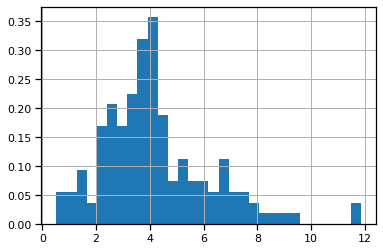

In [125]:
april_h = precip.Apr.hist(normed=True, bins=30)

In [126]:
precip.Apr.values

array([ 4.13,  5.91,  3.59, 11.84,  4.22,  3.62,  9.47,  6.88,  2.88,
        5.26,  5.12,  3.59,  9.12,  3.51,  3.75,  2.36,  2.67,  4.18,
        2.83,  3.84,  2.24,  7.45,  4.11,  4.05,  3.07,  2.92,  5.79,
        3.16,  3.25,  4.04,  4.99,  3.08,  4.  ,  2.35,  1.5 ,  1.75,
        4.66,  4.43,  4.12,  6.1 ,  5.11, 11.73,  1.65,  3.83,  0.72,
        2.49,  4.05,  3.39,  2.66,  8.58,  3.5 ,  4.53,  4.26,  3.55,
        3.74,  2.45,  7.38,  3.22,  3.93,  1.16,  2.44,  7.2 ,  4.17,
        2.24,  4.51,  3.7 ,  3.73,  2.23,  3.96,  5.24,  2.4 ,  4.22,
        2.97,  3.85,  5.51,  3.45,  3.56,  1.15,  5.27,  1.58,  4.75,
        2.01,  4.53,  4.42,  4.62,  4.23,  2.79,  6.35,  2.49,  2.04,
        4.5 ,  6.91,  3.37,  5.86,  5.72,  5.08,  3.4 ,  3.57,  6.03,
        6.81,  3.34,  3.58,  7.  ,  3.97,  3.55,  1.53,  7.87,  2.42,
        7.8 ,  3.67,  4.78,  4.36,  6.8 ,  8.41,  2.91,  0.52,  1.03,
        2.09,  2.68,  1.6 ,  3.35,  0.77,  3.33,  5.72,  3.95,  3.68,
        2.42,  6.31,

In [127]:
wx_hist = np.histogram(precip.Apr.values, bins=100)
wx_hist

(array([1, 1, 1, 0, 1, 2, 0, 0, 2, 3, 1, 0, 0, 3, 0, 4, 7, 3, 2, 2, 3, 3,
        2, 2, 3, 5, 7, 6, 4, 3, 5, 8, 5, 3, 2, 4, 3, 2, 0, 1, 3, 3, 0, 0,
        1, 2, 1, 2, 1, 1, 1, 2, 0, 0, 1, 2, 3, 1, 0, 2, 1, 2, 0, 0, 2, 0,
        0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2], dtype=int64),
 array([ 0.52  ,  0.6332,  0.7464,  0.8596,  0.9728,  1.086 ,  1.1992,
         1.3124,  1.4256,  1.5388,  1.652 ,  1.7652,  1.8784,  1.9916,
         2.1048,  2.218 ,  2.3312,  2.4444,  2.5576,  2.6708,  2.784 ,
         2.8972,  3.0104,  3.1236,  3.2368,  3.35  ,  3.4632,  3.5764,
         3.6896,  3.8028,  3.916 ,  4.0292,  4.1424,  4.2556,  4.3688,
         4.482 ,  4.5952,  4.7084,  4.8216,  4.9348,  5.048 ,  5.1612,
         5.2744,  5.3876,  5.5008,  5.614 ,  5.7272,  5.8404,  5.9536,
         6.0668,  6.18  ,  6.2932,  6.4064,  6.5196,  6.6328,  6.746 ,
         6.8592,  6.9724,  7.0856,  7.1988,  7.312 ,  7.4252,  7.5384,
      

In [128]:
wx_hist[0]

array([1, 1, 1, 0, 1, 2, 0, 0, 2, 3, 1, 0, 0, 3, 0, 4, 7, 3, 2, 2, 3, 3,
       2, 2, 3, 5, 7, 6, 4, 3, 5, 8, 5, 3, 2, 4, 3, 2, 0, 1, 3, 3, 0, 0,
       1, 2, 1, 2, 1, 1, 1, 2, 0, 0, 1, 2, 3, 1, 0, 2, 1, 2, 0, 0, 2, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2], dtype=int64)

Let's use the histogram from precipitation for the month of April as input. First, we'll do it with our prototype, then with the general class we wrote:

In [129]:
precip.Apr.values.min()

0.52

In [130]:
# inputs
h = wx_hist[0]
r = (precip.Apr.values.min(), precip.Apr.values.max())
n = 10000

# we build
x = np.linspace(r[0], r[1], len(h))
x[0], x[len(h)//2], x[len(h)-1]

(0.52, 6.237171717171718, 11.84)

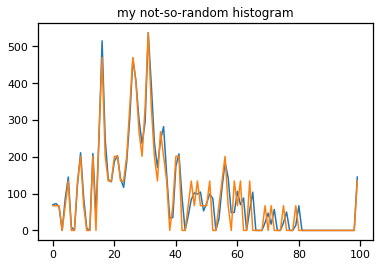

In [131]:
my_random_variates = []
for _ in range(n):
    i = roulette_selection(h)
    if i == len(h) - 1: i -= 1
    my_random_variates.append(random.uniform(x[i], x[i+1]))
    
my_not_so_random_histogram = np.histogram(my_random_variates, bins=len(h))

plt.title("my not-so-random histogram")
plt.plot(my_not_so_random_histogram[0], label='generated histogram')
plt.plot(my_not_so_random_histogram[0].max() / h.max() * h, label='original histogram')
plt.show()

</br >
<center>
<img src="https://media3.giphy.com/media/7NOL7wCK1ddCQTiv51/giphy.gif" width=400 />
</center>

Now let's use the class:

C:\Users\liaoz\Anaconda3\lib\site-packages\ipykernel_launcher.py:80: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.


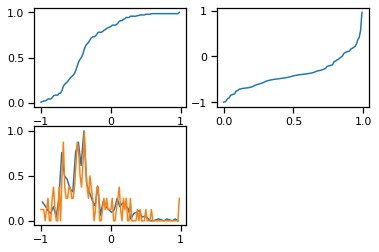

In [132]:
wx_from_hist = GeneralRandom(x = pylab.arange(-1.0, 1.0, .02), p = wx_hist[0], Nrl = 100)
wx_from_hist.self_test()

Let's generate random precipitation values from the month of April that abide by that histogram:

In [133]:
wx_sim_data = wx_from_hist.random()
wx_sim_data

array([[-5.01798519e-01, -7.68313775e-01, -8.63871456e-01,
        -6.61195841e-01, -6.26002038e-01,  6.70492705e-01,
        -1.15142878e-01, -7.01107642e-02, -3.91470722e-01,
        -2.20778179e-01, -6.14963419e-01, -3.98798473e-01,
        -6.94546851e-01, -4.15765744e-01, -3.40928329e-02,
        -8.59799270e-01, -5.15512980e-01, -6.02158879e-01,
         2.00120302e-01, -5.62289272e-01, -2.72607918e-01,
        -4.12176802e-01, -2.15001647e-01, -4.04707344e-01,
        -2.04313484e-01, -6.01256190e-01, -9.16804398e-01,
         7.99275645e-02, -2.05878018e-01,  3.84874258e-01,
        -2.96318894e-01,  4.42328769e-01, -3.94948392e-01,
        -8.06373704e-02, -4.01275332e-01, -3.95612135e-01,
        -3.28430899e-01, -3.87197104e-01, -5.53608946e-01,
        -3.83603474e-01, -6.96210068e-01,  2.68201128e-01,
        -4.85469403e-01,  7.24618388e-02, -7.47160420e-01,
        -3.96168544e-01, -3.83804243e-01, -3.80396249e-01,
        -2.90399985e-01, -7.28190504e-01, -9.96727494e-0

In [134]:
wx_sim_data[0]

array([-5.01798519e-01, -7.68313775e-01, -8.63871456e-01, -6.61195841e-01,
       -6.26002038e-01,  6.70492705e-01, -1.15142878e-01, -7.01107642e-02,
       -3.91470722e-01, -2.20778179e-01, -6.14963419e-01, -3.98798473e-01,
       -6.94546851e-01, -4.15765744e-01, -3.40928329e-02, -8.59799270e-01,
       -5.15512980e-01, -6.02158879e-01,  2.00120302e-01, -5.62289272e-01,
       -2.72607918e-01, -4.12176802e-01, -2.15001647e-01, -4.04707344e-01,
       -2.04313484e-01, -6.01256190e-01, -9.16804398e-01,  7.99275645e-02,
       -2.05878018e-01,  3.84874258e-01, -2.96318894e-01,  4.42328769e-01,
       -3.94948392e-01, -8.06373704e-02, -4.01275332e-01, -3.95612135e-01,
       -3.28430899e-01, -3.87197104e-01, -5.53608946e-01, -3.83603474e-01,
       -6.96210068e-01,  2.68201128e-01, -4.85469403e-01,  7.24618388e-02,
       -7.47160420e-01, -3.96168544e-01, -3.83804243e-01, -3.80396249e-01,
       -2.90399985e-01, -7.28190504e-01, -9.96727494e-01, -4.16066366e-01,
       -6.94864532e-01, -

Let's plot the histogram of these fake precipitation values:

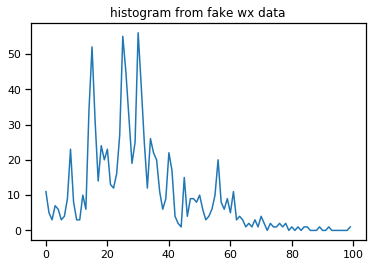

In [135]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.title("histogram from fake wx data")
plt.plot(np.histogram(wx_sim_data[0], bins=100)[0], label='histogram')
plt.show()

Does the histogram from the fake precipitation values look like Tennessee's real April histogram?

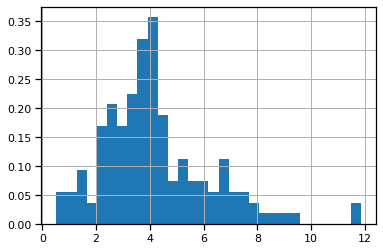

In [136]:
april_h = precip.Apr.hist(normed=True, bins=30)

# Conclusion

Math is by far the best model, since functions give us the *lowest possible model dimensionality reduction*. But when the math is too tough, you can always pick a *program*. The number of SLOC in the program will be much bigger than the number of parameters in your analytic function, but if your model *rocks*, like the one in this notebook, then use it!